In [3]:
# import cv2
import tensorflow as tf
import numpy as np
import Functions.dataFrameTools as dataFrameTools
import Functions.processGen as processGen
import matplotlib.pyplot as plt
import pandas as pd
# from cloudpickle import CloudPickler
# import Functions.checkdf
# import seaborn as sns
from sklearn.neighbors import KernelDensity

from parametricVAE import dVAE, plot_history,freeze_layers_before, unfreeze_all_layers, loadData2, my_loadData2, loadData2, custom_sigmoid_cross_entropy_loss_with_logits



### Fetch all datasets

In [8]:
dfn = dataFrameTools.normalizeDF(0).astype('float32')


visual_df =pd.read_csv("../data/clip_sBIKED_reduced.csv", index_col=0)
columns_to_drop = [col for col in visual_df.columns if 'color' in col]
visual_df.drop(columns=columns_to_drop, inplace=True)
boolean_columns = visual_df.select_dtypes(include=['bool']).columns
visual_df[boolean_columns] = visual_df[boolean_columns].astype(int)
visual_df = visual_df.sort_index(axis=1)
visual_df = visual_df.select_dtypes(include=['number'])
constant_columns = [col for col in visual_df.columns if visual_df[col].nunique() == 1]
visual_df = visual_df.drop(columns=constant_columns)

rated_bikes_df = pd.read_csv("processed_ratings.csv")

all_my_bikes_df = dfn.loc[rated_bikes_df['bid'].unique()]
# all_my_bikes_df = visual_df.loc[rated_bikes_df['bid'].unique()]

average_ratings = rated_bikes_df.groupby('bid')['rating'].mean()
usable_bikes = visual_df.loc[average_ratings[average_ratings > 0.7].index]
unusable_bikes = visual_df.loc[average_ratings[average_ratings < 0.3].index]
meaningfull_bikes_df = pd.concat([usable_bikes, unusable_bikes])
meaningfull_bikes_df['usable'] = meaningfull_bikes_df.index.isin(usable_bikes.index).astype(int)


usable_ids = meaningfull_bikes_df[meaningfull_bikes_df['usable'] == True].index.tolist()
unusable_ids = meaningfull_bikes_df[meaningfull_bikes_df['usable'] == False].index.tolist()

usable_bikes = dfn.loc[usable_ids] 
unusable_bikes = dfn.loc[unusable_ids] 

Loaded Imputed Dataframe in  1.535510540008545 seconds


### Build VAE

In [5]:
# dtrain,dval,dtest,ddims = loadData2()

ddims = 2395

tunedVAE = dVAE(ddims, 128, 0.1, 1e-3).build_vae_keras_model_mean()
tunedVAE.load_weights('model weights/tuned2_redoVAE.h5')
encoder_tuned = tunedVAE.get_layer('encoder')
decoder_tuned = tunedVAE.get_layer('decoder')

latent_usable = encoder_tuned.predict(usable_bikes)
latent_unusable = encoder_tuned.predict(unusable_bikes)

2/2 [==============================] - 0s 5ms/step


### Fit KDEs


In [6]:
kde_usable = KernelDensity(kernel='gaussian', bandwidth=0.5)
kde_usable.fit(latent_usable)
kde_unusable = KernelDensity(kernel='gaussian', bandwidth=0.5)
kde_unusable.fit(latent_unusable)

KernelDensity(bandwidth=0.5)

### Choose bikes to interpolate between

In [7]:
# bikes = [642,2910]
# bikes = [571,2475]
# bikes = [698,1528]
# bikes = [2,721]
# bikes = [241,878]
bikes = [4,61]

# bikes = [844,857]
# 
int_bikes_df = dfn.loc[bikes]

latet_int_bikes = encoder_tuned.predict(int_bikes_df)

1/1 [==============================] - 0s 32ms/step


### Perform both interpolation methods

In [11]:
def linear_interpolation(point1, point2, num_steps=10):
    interpolated_points = []
    point1 = np.array(point1)
    point2 = np.array(point2)
    
    direction = (point2 - point1) / num_steps
    current_point = point1
    
    for _ in range(num_steps):
        interpolated_points.append(current_point)
        current_point = current_point + direction
    
    return np.array(interpolated_points)


def log_likelihoods(point, kde_usable, kde_unusable):
    point = np.reshape(point, (1, -1))  # Make sure the point is in the right shape
    log_likelihood_usable = kde_usable.score_samples(point)
    log_likelihood_unusable = kde_unusable.score_samples(point)
    return log_likelihood_usable, log_likelihood_unusable

def compute_gradient(point, kde_usable, kde_unusable, epsilon = 1e-5):
    num_features = point.shape[0]
    gradient_usable = np.zeros(num_features)
    gradient_unusable = np.zeros(num_features)
    
    for i in range(num_features):
        # Perturb the point slightly in positive and negative direction
        point_plus = np.copy(point)
        point_minus = np.copy(point)
        point_plus[i] += epsilon
        point_minus[i] -= epsilon
        
        # Compute log-likelihoods for perturbed points
        log_likelihood_usable_plus, log_likelihood_unusable_plus = log_likelihoods(point_plus, kde_usable, kde_unusable)
        log_likelihood_usable_minus, log_likelihood_unusable_minus = log_likelihoods(point_minus, kde_usable, kde_unusable)
        
        
        # Approximate gradients
        gradient_usable[i] = (log_likelihood_usable_plus[0] - log_likelihood_usable_minus[0]) / (2 * epsilon)
        gradient_unusable[i] = (log_likelihood_unusable_plus[0] - log_likelihood_unusable_minus[0]) / (2 * epsilon)
    
    return gradient_usable, gradient_unusable


def move_points(points, kde_usable, kde_unusable, step_scale=0.1, max_iter=30):
    new_points = []
    
    for point in points:
        current_point = np.copy(point)  # Ensure we don't modify the original point
        found = False
        counter = 0
        
        while counter < max_iter and not found:
            counter += 1
            log_likelihood_usable, log_likelihood_unusable = log_likelihoods(current_point, kde_usable, kde_unusable)

            if (log_likelihood_usable - log_likelihood_unusable >= np.log(2) and log_likelihood_usable > -44 )  or counter == max_iter: #np.log(2)
                print(f'step{len(new_points)} counter={counter} log_likelihood_usable={log_likelihood_usable}  log_likelihood_unusable= {log_likelihood_unusable}')
                found = True
                new_points.append(current_point)
                break

            gradient_usable, gradient_unusable = compute_gradient(current_point, kde_usable, kde_unusable)
            
            gradient_combined = gradient_usable - gradient_unusable
            
            norm = np.linalg.norm(gradient_combined)
            if norm != 0: 
                gradient_combined /= norm
            
            current_point += step_scale * gradient_combined
            
    return np.array(new_points)


linear_interpolated_points = linear_interpolation(latet_int_bikes[0], latet_int_bikes[1], num_steps=10)
new_points = move_points(linear_interpolated_points, kde_usable, kde_unusable)

# print(linear_interpolated_points)
# print(new_points)

# step0 counter=16 log_likelihood_usable=[-35.61894927]  log_likelihood_unusable= [-36.75954965]
# step1 counter=13 log_likelihood_usable=[-36.52187537]  log_likelihood_unusable= [-38.14365192]
# step2 counter=10 log_likelihood_usable=[-39.9933963]  log_likelihood_unusable= [-41.60792554]
# step3 counter=7 log_likelihood_usable=[-44.8389019]  log_likelihood_unusable= [-45.88933306]
# step4 counter=9 log_likelihood_usable=[-45.47885109]  log_likelihood_unusable= [-46.61382103]
# step5 counter=9 log_likelihood_usable=[-43.16091984]  log_likelihood_unusable= [-44.71457594]
# step6 counter=9 log_likelihood_usable=[-43.21710687]  log_likelihood_unusable= [-44.02556534]
# step7 counter=10 log_likelihood_usable=[-44.5397711]  log_likelihood_unusable= [-45.49001756]
# step8 counter=14 log_likelihood_usable=[-43.5195427]  log_likelihood_unusable= [-44.41289054]
# step9 counter=19 log_likelihood_usable=[-43.08538145]  log_likelihood_unusable= [-44.05764202]

step0 counter=1 log_likelihood_usable=[-31.89627596]  log_likelihood_unusable= [-65.96411814]
step1 counter=1 log_likelihood_usable=[-32.12488621]  log_likelihood_unusable= [-64.69819959]
step2 counter=1 log_likelihood_usable=[-32.81113464]  log_likelihood_unusable= [-63.48348774]
step3 counter=1 log_likelihood_usable=[-33.95489039]  log_likelihood_unusable= [-61.35083143]
step4 counter=1 log_likelihood_usable=[-35.54622184]  log_likelihood_unusable= [-58.91831874]
step5 counter=1 log_likelihood_usable=[-36.92382293]  log_likelihood_unusable= [-56.84026068]
step6 counter=1 log_likelihood_usable=[-35.5485378]  log_likelihood_unusable= [-55.19138132]
step7 counter=1 log_likelihood_usable=[-33.95667543]  log_likelihood_unusable= [-53.96451336]
step8 counter=1 log_likelihood_usable=[-32.81247169]  log_likelihood_unusable= [-53.14263482]
step9 counter=1 log_likelihood_usable=[-32.12588704]  log_likelihood_unusable= [-52.70760074]
[[-0.00306606 -0.65246356  0.0431345  ...  0.03830384  0.0857

### Compare interpolation methods in two dimension


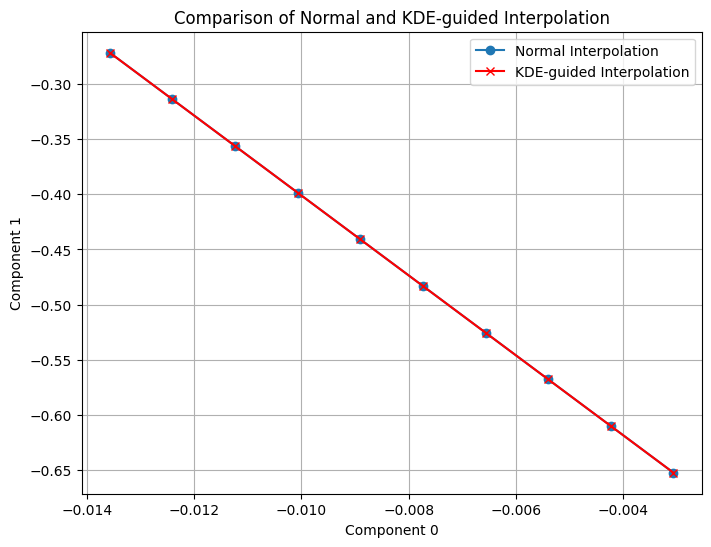

In [12]:

plt.figure(figsize=(8, 6))
comp1 = 0
comp2 = 1

plt.plot(linear_interpolated_points[:, comp1], linear_interpolated_points[:, comp2], 'o-', label='Normal Interpolation')

if len(new_points) > 0:
    plt.plot(new_points[:, comp1], new_points[:, comp2], 'x-', label='KDE-guided Interpolation', color='r')

plt.title('Comparison of Normal and KDE-guided Interpolation')
plt.xlabel(f'Component {comp1}')
plt.ylabel(f'Component {comp2}')
plt.legend()
plt.grid(True)
plt.show()

### Generate KDE-guided points

In [13]:
res=(tf.math.sigmoid(decoder_tuned.predict(new_points))).numpy()
indices=[f'kde_guided{i}' for i in range(len(new_points))]
meandf=pd.DataFrame(res, index=indices, columns=dfn.columns)
meandf.to_csv(f"../data/kde_guided.csv")  # Saving to CSV
processGen.processGen(f"kde_guided", denorm=True)

1/1 [==============================] - 0s 145ms/step
Loaded Imputed Dataframe in  1.468644380569458 seconds
1.0 fraction valid


c:\Users\fabie\Desktop\Thesis1\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  newdf.at[:,column]=df[column]
c:\Users\fabie\Desktop\Thesis1\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  newdf.at[:,column]=df[column]
c:\Users\fabie\Desktop\Thesis1\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

One-hot encoding 106 features
Onehot Completed in 0.4742472171783447 seconds
Loaded Imputed Dataframe in  1.5938587188720703 seconds


c:\Users\fabie\Desktop\Thesis1\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col]=[0]*len(df.index)
c:\Users\fabie\Desktop\Thesis1\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col]=[0]*len(df.index)
c:\Users\fabie\Desktop\Thesis1\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

,SSSIDECX3,SSSIDECX2,SSSIDECX1,SSSIDECY2,SSSIDECY1,STEMBENDS,FRONTROTORBOLTS,Shoe up angle,Down tube front diameter,LRTHICK,...,Saddle type OHCLASS: fi'zi:k Arione,Saddle type OHCLASS: fi'zi:k Arione TRI,Saddle type OHCLASS: fi'zi:k Gobi,Saddle type OHCLASS: fi'zi:k Tundra,TRACK_ERGO OHCLASS: 1,FRONTPANNIER style OHCLASS: 1,Top tube type OHCLASS: 1,BRAZEonFDTYPE OHCLASS: FD9070F,CSAUX3_MM_RATIO OHCLASS: 1,bottle SEATTUBE0 show OHCLASS: True
kde_guided0,61.344799,130.393754,318.889263,-11.544166,2.809938,0,6,36,32.607744,10,...,0,0,0,0,0,0,0,0,0,0
kde_guided1,62.992591,132.731594,315.682873,-9.846808,1.450170,0,6,36,33.028575,10,...,0,0,0,0,0,0,0,0,0,0
kde_guided2,67.426609,134.667524,311.405442,-7.735707,3.672558,0,6,36,33.957280,10,...,0,0,0,0,0,0,0,0,0,0
kde_guided3,73.189765,136.314116,303.760658,-4.797866,7.166272,0,6,35,34.998951,10,...,0,0,0,0,0,0,0,0,0,0
kde_guided4,81.151011,138.245001,302.685764,-2.573338,9.856115,0,6,35,36.277735,10,...,0,0,0,0,0,0,0,0,0,0
kde_guided5,93.094812,142.030860,311.478819,-3.237560,11.488498,0,6,35,37.766063,10,...,0,0,0,0,0,0,0,0,0,0
kde_guided6,108.208717,143.660025,314.193766,-4.923934,15.792270,0,6,35,38.598040,10,...,0,0,0,0,0,0,0,0,0,0
kde_guided7,124.119855,142.859513,311.288912,-6.298846,15.738141,0,6,36,38.734527,10,...,0,0,0,0,0,0,0,0,0,0
kde_guided8,133.031238,139.820337,307.274764,-7.211702,13.940820,0,6,36,39.085259,10,...,0,0,0,0,0,0,0,0,0,0
kde_guided9,136.199424,138.470492,302.865791,-8.273617,13.717960,0,6,36,38.786725,10,...,0,0,0,0,0,0,0,0,0,0


### Generate linearly interpolated points

In [14]:
res=(tf.math.sigmoid(decoder_tuned.predict(linear_interpolated_points))).numpy()
indices=[f'inter{i}' for i in range(len(linear_interpolated_points))]
meandf=pd.DataFrame(res, index=indices, columns=dfn.columns)
meandf.to_csv(f"../data/inter.csv")  # Saving to CSV
processGen.processGen(f"inter", denorm=True)

1/1 [==============================] - 0s 18ms/step
Loaded Imputed Dataframe in  1.4328663349151611 seconds
1.0 fraction valid


c:\Users\fabie\Desktop\Thesis1\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  newdf.at[:,column]=df[column]
c:\Users\fabie\Desktop\Thesis1\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  newdf.at[:,column]=df[column]
c:\Users\fabie\Desktop\Thesis1\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

One-hot encoding 106 features
Onehot Completed in 0.7436325550079346 seconds
Loaded Imputed Dataframe in  1.7956023216247559 seconds


c:\Users\fabie\Desktop\Thesis1\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col]=[0]*len(df.index)
c:\Users\fabie\Desktop\Thesis1\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col]=[0]*len(df.index)
c:\Users\fabie\Desktop\Thesis1\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

,SSSIDECX3,SSSIDECX2,SSSIDECX1,SSSIDECY2,SSSIDECY1,STEMBENDS,FRONTROTORBOLTS,Shoe up angle,Down tube front diameter,LRTHICK,...,Saddle type OHCLASS: fi'zi:k Arione,Saddle type OHCLASS: fi'zi:k Arione TRI,Saddle type OHCLASS: fi'zi:k Gobi,Saddle type OHCLASS: fi'zi:k Tundra,TRACK_ERGO OHCLASS: 1,FRONTPANNIER style OHCLASS: 1,Top tube type OHCLASS: 1,BRAZEonFDTYPE OHCLASS: FD9070F,CSAUX3_MM_RATIO OHCLASS: 1,bottle SEATTUBE0 show OHCLASS: True
inter0,61.344799,130.393754,318.889263,-11.544166,2.809938,0,6,36,32.607744,10,...,0,0,0,0,0,0,0,0,0,0
inter1,62.992591,132.731594,315.682873,-9.846808,1.450170,0,6,36,33.028575,10,...,0,0,0,0,0,0,0,0,0,0
inter2,67.426609,134.667524,311.405442,-7.735707,3.672558,0,6,36,33.957280,10,...,0,0,0,0,0,0,0,0,0,0
inter3,73.189765,136.314116,303.760658,-4.797866,7.166272,0,6,35,34.998951,10,...,0,0,0,0,0,0,0,0,0,0
inter4,81.151011,138.245001,302.685764,-2.573338,9.856115,0,6,35,36.277735,10,...,0,0,0,0,0,0,0,0,0,0
inter5,93.094812,142.030860,311.478819,-3.237560,11.488498,0,6,35,37.766063,10,...,0,0,0,0,0,0,0,0,0,0
inter6,108.208717,143.660025,314.193766,-4.923934,15.792270,0,6,35,38.598040,10,...,0,0,0,0,0,0,0,0,0,0
inter7,124.119855,142.859513,311.288912,-6.298846,15.738141,0,6,36,38.734527,10,...,0,0,0,0,0,0,0,0,0,0
inter8,133.031238,139.820337,307.274764,-7.211702,13.940820,0,6,36,39.085259,10,...,0,0,0,0,0,0,0,0,0,0
inter9,136.199424,138.470492,302.865791,-8.273617,13.717960,0,6,36,38.786725,10,...,0,0,0,0,0,0,0,0,0,0


### Regenerate Original Chosen Bikes

In [36]:
all_latent = np.concatenate((latent_usable, latent_unusable))
res=(tf.math.sigmoid(decoder_tuned.predict(all_latent))).numpy()
indices=[f'usable{i}' if i < len(usable_ids) else f'unusable{i-len(usable_ids)}' for i in range(len(usable_ids) + len(unusable_ids))]
meandf=pd.DataFrame(res, index=indices, columns=dfn.columns)
meandf.to_csv(f"../data/all.csv")  # Saving to CSV
processGen.processGen(f"all", denorm=True)

2/2 [==============================] - 0s 3ms/step
Loaded Imputed Dataframe in  1.4300596714019775 seconds
Model unusable18 Seatpost too short
Model unusable23 HTLX + HTUX>HTL
0.9622641509433962 fraction valid


c:\Users\fabie\Desktop\Thesis1\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  newdf.at[:,column]=df[column]
c:\Users\fabie\Desktop\Thesis1\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  newdf.at[:,column]=df[column]
c:\Users\fabie\Desktop\Thesis1\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

One-hot encoding 106 features
Onehot Completed in 0.3937990665435791 seconds
Loaded Imputed Dataframe in  1.3799412250518799 seconds


c:\Users\fabie\Desktop\Thesis1\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col]=[0]*len(df.index)
c:\Users\fabie\Desktop\Thesis1\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col]=[0]*len(df.index)
c:\Users\fabie\Desktop\Thesis1\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

,SSSIDECX3,SSSIDECX2,SSSIDECX1,SSSIDECY2,SSSIDECY1,STEMBENDS,FRONTROTORBOLTS,Shoe up angle,Down tube front diameter,LRTHICK,...,Saddle type OHCLASS: Specialized Alias,Saddle type OHCLASS: Specialized Avatar 130,Saddle type OHCLASS: Specialized Henge,Saddle type OHCLASS: Specialized Jet 143,Saddle type OHCLASS: Specialized Phenom,Saddle type OHCLASS: Specialized Toupe,Saddle type OHCLASS: WILIER Selle Italia,Saddle type OHCLASS: fi'zi:k Antares,Saddle type OHCLASS: fi'zi:k Arione TRI,BRAZEonFDTYPE OHCLASS: FD9070F
usable0,61.344793,130.393754,318.889263,-11.544162,2.809938,0,6,36,32.607744,10,...,0,0,0,0,0,0,0,0,0,0
usable1,66.783025,135.629048,301.650586,-8.491892,8.828099,0,6,35,32.746770,10,...,0,0,0,0,0,0,0,0,0,0
usable2,64.307765,134.813684,317.742933,-13.939938,7.891075,0,6,36,38.248512,10,...,0,0,0,0,0,0,0,0,0,0
usable3,137.153484,136.902445,295.690380,-10.203837,14.422981,0,6,36,38.519255,10,...,0,0,0,0,0,0,0,0,0,0
usable4,84.435238,130.508259,274.442889,-8.528756,21.478970,0,6,35,40.823237,10,...,0,0,0,0,0,0,0,0,0,0
usable5,72.611187,146.665428,185.632256,-9.163924,-11.931382,0,6,35,37.737723,10,...,0,0,0,0,0,0,0,0,0,0
usable6,67.780026,125.653545,257.721439,-16.363131,9.900696,0,6,36,36.550319,10,...,0,0,0,0,0,0,0,0,0,0
usable7,82.253917,152.089755,352.741798,2.992174,14.886371,0,6,36,35.795019,10,...,0,0,0,0,0,0,0,0,0,0
usable8,126.075632,133.591775,311.223349,-12.273690,17.410994,0,6,36,39.556344,10,...,0,0,0,0,0,0,0,0,0,0
usable9,65.434482,154.785173,337.260829,1.514051,15.375590,0,6,35,38.873878,10,...,0,0,0,0,0,0,0,0,0,0
